1. Instantiate wine_df

In [3]:
import numpy as np
from gensim.models import Word2Vec
import pandas as pd

In [4]:
# Define the path to the CSV file in GCS
# csv_path = "gs://vino-verdict/data/cleaned_wine_df.csv"

# Read the CSV using pandas
# df = pd.read_csv(csv_path)

# Offline Usage
wine_df = pd.read_csv('../cleaned_wine_df.csv')

In [5]:
wine_df.head(3)

,country,description,points,price,province,region_1,title,variety,winery,year
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,19.0,Sicily & Sardinia,Etna,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,NaN,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013


/home/unix_blamb/.pyenv/versions/3.10.6/envs/vino_verdict/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


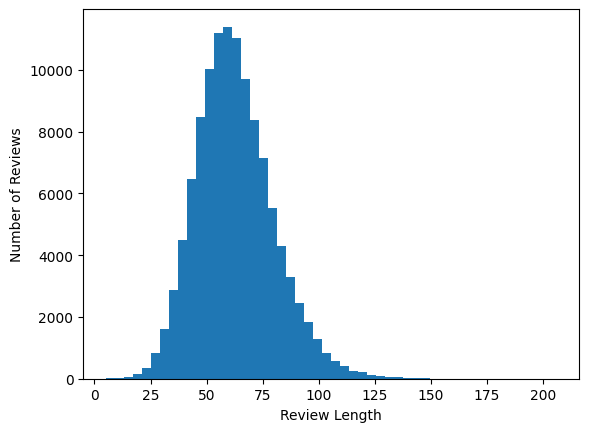

In [6]:
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import torch

# Load pre-trained model tokenizer (vocabulary)
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
wine_df['review_length'] = wine_df['description'].apply(lambda x: len(tokenizer.tokenize(x)))
plt.hist(wine_df['review_length'], bins=50)
plt.xlabel('Review Length')
plt.ylabel('Number of Reviews')
plt.show()

In [7]:
# Select 10% of your data
wine_sample_df = wine_df.sample(frac=0.1, random_state=42)

2. Use Bert to tokenize the text and get the embedding of each token and return sentiement score of each sentence

In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained model
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

# Send model to device
model = model.to(device)


BATCH_SIZE = 32  # You can adjust this based on available memory

def get_sentiments_batched(reviews):
    # Tokenize a batch of reviews
    inputs = tokenizer(reviews, return_tensors="pt", padding='max_length', truncation=True, max_length=128)
    
    # Send tensors to device (GPU if available)
    for key in inputs:
        inputs[key] = inputs[key].to(device)

    # Get model outputs for the batch
    outputs = model(**inputs)
    
    # Get sentiment predictions for the batch
    _, predictions = torch.max(outputs[0], dim=1)
    
    return predictions.cpu().numpy()

# Split data into batches and apply sentiment analysis batch-wise
predictions = []
for i in range(0, len(wine_sample_df), BATCH_SIZE):
    batch_reviews = wine_sample_df['description'].iloc[i:i+BATCH_SIZE].tolist()
    batch_predictions = get_sentiments_batched(batch_reviews)
    predictions.extend(batch_predictions)

wine_sample_df['predicted_sentiment'] = predictions

In [9]:
wine_sample_df.head()

,country,description,points,price,province,region_1,title,variety,winery,year,review_length,predicted_sentiment
28358,Spain,A fruit-forward nose with earthy plum and berr...,85,9.000000,Central Spain,Vino de la Tierra de Castilla,Finca La Estacada 2015 Ocho y Media Tinto Vela...,Tinto Velasco,Finca La Estacada,2015,54,3
64420,Portugal,"Rough around the edges, this is a wine with so...",86,34.500000,Alentejano,NaN,Cortes de Cima 2009 Trincadeira (Alentejano),Trincadeira,Cortes de Cima,2009,37,2
8074,US,"Vanilla candle wax, pollen and peaches-and-cre...",85,25.000000,Texas,Texas,Brennan 2014 Reserve Viognier (Texas),Viognier,Brennan,2014,66,3
70317,Portugal,"This wine is soft and bland, just hinting at f...",83,10.181818,Lisboa,NaN,Casa Santos Lima 2014 Portuga White (Lisboa),Portuguese White,Casa Santos Lima,2014,19,4
13996,Italy,The 2007 vintage was a hot one and La Vignone ...,86,13.000000,Piedmont,Barbera d'Asti,Pico Maccario 2007 Lavignone (Barbera d'Asti),Barbera,Pico Maccario,2007,55,3


In [10]:
def categorize_points(points):
    if 80 <= points <= 89:
        return 'not-so-highly rated'
    else:  # 90 to 100
        return 'highly rated'

wine_sample_df['points_category'] = wine_sample_df['points'].apply(categorize_points)

In [11]:
def sentiment_to_label(sentiment):
    if sentiment in [1, 2, 3]:
        return 0  # 'not-so-highly rated'
    else:
        return 1  # 'highly rated'

In [12]:
wine_sample_df.head(3)

,country,description,points,price,province,region_1,title,variety,winery,year,review_length,predicted_sentiment,points_category
28358,Spain,A fruit-forward nose with earthy plum and berr...,85,9.0,Central Spain,Vino de la Tierra de Castilla,Finca La Estacada 2015 Ocho y Media Tinto Vela...,Tinto Velasco,Finca La Estacada,2015,54,3,not-so-highly rated
64420,Portugal,"Rough around the edges, this is a wine with so...",86,34.5,Alentejano,NaN,Cortes de Cima 2009 Trincadeira (Alentejano),Trincadeira,Cortes de Cima,2009,37,2,not-so-highly rated
8074,US,"Vanilla candle wax, pollen and peaches-and-cre...",85,25.0,Texas,Texas,Brennan 2014 Reserve Viognier (Texas),Viognier,Brennan,2014,66,3,not-so-highly rated


In [13]:
wine_sample_df['predicted_label'] = wine_sample_df['predicted_sentiment'].apply(sentiment_to_label)
wine_sample_df['true_label'] = wine_sample_df['points_category'].map({'not-so-highly rated': 0, 'highly rated': 1})

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

y_true = wine_sample_df['true_label']
y_pred = wine_sample_df['predicted_label']

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Accuracy
acc = accuracy_score(y_true, y_pred)

# Classification Report
report = classification_report(y_true, y_pred, target_names=['not-so-highly rated', 'highly rated'])

print("Confusion Matrix:")
print(cm)
print("\nAccuracy:", acc)
print("\nClassification Report:\n", report)

Confusion Matrix:
[[4958 2170]
 [1739 2693]]

Accuracy: 0.6618512110726643

Classification Report:
                      precision    recall  f1-score   support

not-so-highly rated       0.74      0.70      0.72      7128
       highly rated       0.55      0.61      0.58      4432

           accuracy                           0.66     11560
          macro avg       0.65      0.65      0.65     11560
       weighted avg       0.67      0.66      0.66     11560

